In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.ops import array_ops
# from tensorflow.keras import datasets, layers, models, utils
from keras import layers, datasets, utils, models

Using TensorFlow backend.


In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()

train_images = train_images.reshape((50000, 32, 32, 3))
test_images = test_images.reshape((10000, 32, 32, 3))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
# train_images, test_images = train_images - 0.5, test_images - 0.5
# train_images, test_images = train_images * 2, test_images * 2

# To one-hot
train_labels = utils.to_categorical(train_labels, 100)
test_labels = utils.to_categorical(test_labels, 100)

In [7]:
model = models.Sequential()

model.add(layers.Convolution2D(32, 3, padding='same',
                               input_shape=(32, 32, 3)))
model.add(layers.Activation('relu'))
model.add(layers.Convolution2D(32, 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Convolution2D(64, 3, padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Convolution2D(64, 3))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

In [4]:
model.predict(train_images[:2])

array([[ -1.79332383e-02,   2.75854580e-03,   1.54008701e-01,
          3.85200009e-02,  -1.74595043e-02,  -1.42379827e-03,
          2.80976072e-02,  -2.83561740e-02,  -1.42732024e-01,
         -6.32687286e-02,   3.02754398e-02,   5.50214574e-03,
         -5.43375723e-02,   6.56293705e-02,   1.53363481e-01,
          2.24670656e-02,  -9.35273021e-02,  -1.34679228e-01,
         -5.28472848e-03,  -8.70812684e-02,   1.33351117e-01,
         -4.31897007e-02,   8.14656839e-02,   1.43965244e-01,
          1.08156428e-01,   1.24173999e-01,  -1.64839789e-01,
         -6.42225370e-02,  -1.33592337e-01,   2.03261420e-01,
          8.75403434e-02,   3.29893641e-02,  -1.04771584e-01,
         -2.58247405e-02,   4.19019200e-02,   9.45553184e-05,
         -2.57763900e-02,   1.18809983e-01,   4.56755143e-03,
         -1.85587376e-01,   7.76786432e-02,  -7.58660771e-03,
         -8.73109400e-02,   4.55091372e-02,   1.59836143e-01,
          6.69775009e-02,  -2.39077210e-01,  -1.04999736e-01,
        

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [6]:
def softmax_loss(t=1.0):

    t = float(t)
    
    def softmax_loss_fixed(y_true, logits):
        """Softmax loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is raw logits
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        zeros = array_ops.zeros_like(logits, dtype=logits.dtype)
        ones = array_ops.ones_like(logits, dtype=logits.dtype)
        
        logit_y = tf.reduce_sum(tf.multiply(y_true, logits), axis=-1, keepdims=True)
        I_k = array_ops.where(logit_y >= logits, zeros, ones)
        
        h = tf.exp(tf.multiply(t - 1., tf.multiply(logits + ones, I_k)))
        
        # softmax = tf.exp(logits) / tf.reduce_sum(tf.multiply(tf.exp(logits), h))
#         softmax = tf.exp(logits) / (tf.reshape(
#             tf.reduce_sum(tf.multiply(tf.exp(logits), h)), 
#             [-1, 1]) + epsilon)
        softmax = tf.exp(logits) / (tf.reduce_sum(tf.multiply(tf.exp(logits), h)) + epsilon)
        # softmax = tf.nn.softmax(logits)
        # softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits))
        
        # We add epsilon because log(0) = nan
        softmax = tf.add(softmax, epsilon)
        ce = tf.multiply(y_true, -tf.log(softmax))
        return tf.reduce_mean(ce)
    
    return softmax_loss_fixed

In [8]:
import math

def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
from keras import callbacks
lrate = callbacks.LearningRateScheduler(step_decay)
callbacks_list = [lrate]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history1 = model.fit(train_images, train_labels, epochs=30,
                     validation_data=(test_images, test_labels), callbacks=callbacks_list);

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 8s 150us/step - loss: 3.7086 - acc: 0.1334 - val_loss: 3.1493 - val_acc: 0.2383
Epoch 2/30
50000/50000 [==============================] - 8s 166us/step - loss: 2.9109 - acc: 0.2792 - val_loss: 2.7674 - val_acc: 0.3169
Epoch 3/30
50000/50000 [==============================] - 8s 156us/step - loss: 2.5512 - acc: 0.3486 - val_loss: 2.5161 - val_acc: 0.3646
Epoch 4/30
50000/50000 [==============================] - 8s 153us/step - loss: 2.2890 - acc: 0.4087 - val_loss: 2.4167 - val_acc: 0.3905
Epoch 5/30
50000/50000 [==============================] - 8s 151us/step - loss: 2.0890 - acc: 0.4492 - val_loss: 2.4157 - val_acc: 0.3903
Epoch 6/30
50000/50000 [==============================] - 8s 151us/step - loss: 1.9166 - acc: 0.4841 - val_loss: 2.4319 - val_acc: 0.4010
Epoch 7/30
50000/50000 [==============================] - 7s 143us/step - loss: 1.7686 - acc: 0.5203 - val_loss: 2.3821 - 

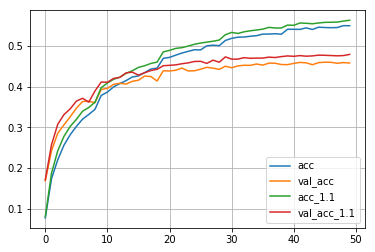

In [18]:
# own softmax with tf.reshape and LRS
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.plot(history1.history['acc'], label='acc_1.1')
plt.plot(history1.history['val_acc'], label='val_acc_1.1')
plt.legend()
plt.grid();

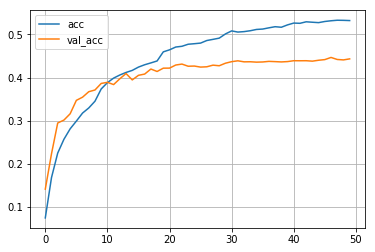

In [12]:
# own softmax with tf.reshape, LRS, t=1.1
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.grid();

In [23]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

10000/10000 [==============================] - 0s 35us/step
0.9938


In [25]:
model.add(tf.keras.layers.Activation('softmax'))
model.compile(optimizer='adam',
              loss=softmax_loss(),
              metrics=['accuracy'])
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

10000/10000 [==============================] - 0s 46us/step
0.9938


In [8]:
# -*- coding: utf-8 -*-
from keras import backend as K
from keras.engine.topology import Layer
# from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Layer
# from tensorflow.keras.layers import activations, initializers, regularizers, constraints, Lambda
# from tensorflow.keras.engine import InputSpec
import tensorflow as tf
import numpy as np

class AMSoftmax(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(AMSoftmax, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(AMSoftmax, self).build(input_shape)


    def call(self, inputs):
        inputs = tf.nn.l2_normalize(inputs, dim=1)  # input_l2norm
        self.kernel = tf.nn.l2_normalize(self.kernel, dim=0)   # W_l2norm

        cosine = K.dot(inputs, self.kernel)  # cos = input_l2norm * W_l2norm
        return cosine


    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)



def amsoftmax_loss(y_true, y_pred):
    scale=30.0
    margin=0.35

    label = tf.reshape(tf.argmax(y_true, axis=-1), shape=(-1,1))
    label = tf.cast(label, dtype=tf.int32) # y
    batch_range = tf.reshape(tf.range(tf.shape(y_pred)[0]),shape=(-1,1)) # 0~batchsize-1
    indices_of_groundtruth = tf.concat([batch_range, tf.reshape(label,shape=(-1,1))], axis=1) # 2columns vector, 0~batchsize-1 and label
    groundtruth_score = tf.gather_nd(y_pred, indices_of_groundtruth) # score of groundtruth

    m = tf.constant(margin,name='m')
    s = tf.constant(scale,name='s')
        
    added_margin = tf.cast(tf.greater(groundtruth_score,m),dtype=tf.float32)*m # if groundtruth_score>m, groundtruth_score-m
    added_margin = tf.reshape(added_margin,shape=(-1,1))
    added_embeddingFeature = tf.subtract(y_pred, y_true*added_margin)*s # s(cos_theta_yi-m), s(cos_theta_j)

    cross_ent = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=added_embeddingFeature)
    loss = tf.reduce_mean(cross_ent)
    return loss

In [29]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.layers import Dense, Activation,BatchNormalization
from keras.layers import activations, initializers, regularizers, constraints, Lambda
from keras.engine import InputSpec
import tensorflow as tf
import numpy as np

class AMSoftmax(Layer):
    def __init__(self, units, s, m,
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=None,
                 kernel_constraint=None,
                 **kwargs
                 ):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(AMSoftmax, self).__init__(**kwargs)
        self.units = units
        self.s = s
        self.m = m
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True


    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.bias = None

        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True


    def call(self, inputs, **kwargs):
        inputs = tf.nn.l2_normalize(inputs, dim=-1)
        self.kernel = tf.nn.l2_normalize(self.kernel, dim=(0, 1))   # W归一化

        dis_cosin = K.dot(inputs, self.kernel)
        psi = dis_cosin - self.m

        e_costheta = K.exp(self.s * dis_cosin)
        e_psi = K.exp(self.s * psi)
        sum_x = K.sum(e_costheta, axis=-1, keepdims=True)

        temp = e_psi - e_costheta
        temp = temp + sum_x

        output = e_psi / temp
        return output

In [30]:
def amsoftmax_loss(y_true, y_pred):
    d1 = K.sum(y_true * y_pred, axis=-1)
    d1 = K.log(K.clip(d1, K.epsilon(), None))
    loss = -K.mean(d1, axis=-1)
    return loss